In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo

Cloning into 'yolov5'...
remote: Enumerating objects: 9212, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 9212 (delta 3), reused 12 (delta 3), pack-reused 9199
Receiving objects: 100% (9212/9212), 9.57 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (6403/6403), done.


In [2]:
!git clone https://github.com/tangsanli5201/DeepPCB.git

Cloning into 'DeepPCB'...
remote: Enumerating objects: 4753, done.
remote: Total 4753 (delta 0), reused 0 (delta 0), pack-reused 4753
Receiving objects: 100% (4753/4753), 85.81 MiB | 28.03 MiB/s, done.
Resolving deltas: 100% (191/191), done.
Checking out files: 100% (4548/4548), done.


In [10]:
import yaml
import glob
import os
import shutil
from tqdm import tqdm
import cv2
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [11]:
os.makedirs('/content/tmp/images/train', exist_ok=True)
os.makedirs('/content/tmp/images/val', exist_ok=True)
os.makedirs('/content/tmp/images/test', exist_ok=True)
os.makedirs('/content/tmp/labels/train', exist_ok=True)
os.makedirs('/content/tmp/labels/val', exist_ok=True)
os.makedirs('/content/tmp/labels/test', exist_ok=True)


In [12]:
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.9.0+cu102 (CPU)


In [13]:
folder_img_dir = glob.glob('pcb_defect/DeepPCB-master/**/*.jpg', recursive=True)

train_val = []
test = []

with open('/content/DeepPCB/PCBData/test.txt') as f:
    for line in f.readlines():
        test.append(line)

with open('/content/DeepPCB/PCBData/trainval.txt') as f1:
    for line in f1.readlines():
        train_val.append(line)

val_split = int(len(train_val) * 0.1)
random.seed(101)
random.shuffle(train_val)

train = train_val[val_split:]  # create train dataset from train_val text file
val = train_val[:val_split]  # create val dataset from train_val text file

In [17]:
def to_csv(data):
    columns = list(data.keys())
    values = list(data.values())
    arr_len = len(values)
    df = pd.DataFrame(np.array(values, dtype=object).reshape(1, arr_len), columns=columns).reset_index()
    # print(df)
    return df
df_all = []

In [18]:
datasets = [train, val, test]
dir_nme = ['train', 'val', 'test']
for k in tqdm(datasets):
    folder_num = (datasets.index(k))
    for i in tqdm(k):
        data = {}
        for j in i.split(" "):
            print_buffer = []
            if '.jpg' in j:
                path_jpg = '/content/DeepPCB/PCBData/' + j
                head_img, tail_img = os.path.split(path_jpg)
                # print(head)

                org_name = (tail_img.strip('.jpg'))
                # print(tail+'_test.jpg')

                jpg_path = (head_img + '/' + org_name + '_test.jpg')
                img_read = cv2.imread(jpg_path)
                shutil.copy(jpg_path, '/content/tmp/images/' + str(dir_nme[folder_num]))
                os.rename('/content/tmp/images/' + str(dir_nme[folder_num]) + '/' + org_name + '_test.jpg',
                          '/content/tmp/images/' + str(dir_nme[folder_num]) + '/' + tail_img)

            if '.txt' in j:
                path_txt = '/content/DeepPCB/PCBData/' + j.strip('\n')

                with open(path_txt, 'r') as f:
                    for line in f.readlines():
                        annot = (line.strip("\n").split(" "))

                        x_min = int(annot[0])
                        y_min = int(annot[1])
                        x_max = int(annot[2])
                        y_max = int(annot[3])
                        label = int(annot[4])

                        # Transform the bbox co-ordinates as per the format required by YOLO v5
                        b_center_x = (x_min + x_max) / 2
                        b_center_y = (y_min + y_max) / 2
                        b_width = (x_max - x_min)
                        b_height = (y_max - y_min)

                        # Normalise the co-ordinates by the dimensions of the image
                        image_w, image_h, image_c = img_read.shape
                        b_center_x /= image_w
                        b_center_y /= image_h
                        b_width /= image_w
                        b_height /= image_h

                        print_buffer.append(
                            "{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label, b_center_x, b_center_y, b_width, b_height))

                        head_txt, tail_txt = os.path.split(path_txt)
                        # print(tail_txt)

                        print("\n".join(print_buffer),
                              file=open('/content/tmp/labels/' + dir_nme[folder_num] + '/' + tail_txt.strip('\n'), "w"))

                        id = tail_txt.strip('.txt')

                        data['id'] = id
                        data['label'] = label
                        data['x_min'] = x_min
                        data['y_min'] = y_min
                        data['x_max'] = x_max
                        data['y_max'] = y_max
                        data['b_center_x'] = b_center_x
                        data['b_center_y'] = b_center_y
                        data['b_width'] = b_width
                        data['b_height'] = b_height
                        data['image_w'] = image_w
                        data['image_h'] = image_h
                        data['split'] = dir_nme[folder_num]

                        # Convert Dic data to  dataframe

                        df = to_csv(data)
                        df_all.append(df)



final_df = pd.concat(df_all, ignore_index=True)

del final_df['index']

print(final_df)

final_df.to_csv('meta.csv', index=False)

100%|██████████| 3/3 [00:22<00:00,  7.46s/it]


             id label x_min y_min  ...   b_height image_w image_h  split
0      20085138     1    81   467  ...   0.059375     640     640  train
1      20085138     2    52   564  ...  0.0453125     640     640  train
2      20085138     2     4   568  ...  0.0484375     640     640  train
3      20085138     4   266   486  ...   0.046875     640     640  train
4      20085138     4   410   529  ...  0.0453125     640     640  train
...         ...   ...   ...   ...  ...        ...     ...     ...    ...
10008  12000593     1   271   349  ...    0.06875     640     640   test
10009  12000593     2   182   160  ...   0.071875     640     640   test
10010  12000593     2   330   131  ...  0.0546875     640     640   test
10011  12000593     3   375   180  ...       0.05     640     640   test
10012  12000593     4   329   274  ...    0.04375     640     640   test

[10013 rows x 13 columns]


In [36]:
df_test=pd.read_csv('/content/yolov5/meta.csv')

In [37]:
test_data=df_test.loc[df_test['split']=='test']

In [60]:
test_data.head(5)

,id,label,x_min,y_min,x_max,y_max,b_center_x,b_center_y,b_width,b_height,image_w,image_h,split
6873,20085291,1,263,63,299,90,0.439063,0.119531,0.056250,0.042188,640,640,test
6874,20085291,2,201,266,251,294,0.353125,0.437500,0.078125,0.043750,640,640,test
6875,20085291,3,296,350,322,376,0.482812,0.567187,0.040625,0.040625,640,640,test
6876,20085291,4,419,333,448,361,0.677344,0.542188,0.045312,0.043750,640,640,test
6877,20085291,5,341,236,370,267,0.555469,0.392969,0.045312,0.048438,640,640,test


In [96]:
classes = {0: "background (not used)", 1: "open", 2: "short", 3: "mousebite", 4: "spur", 5: "copper", 6: "pin-hole"}

['/content/DeepPCB/PCBData/group20085/20085_not/20085291.txt']
/content/tmp/images/test/20085291.jpg
['/content/DeepPCB/PCBData/group20085/20085_not/20085292.txt']
/content/tmp/images/test/20085292.jpg


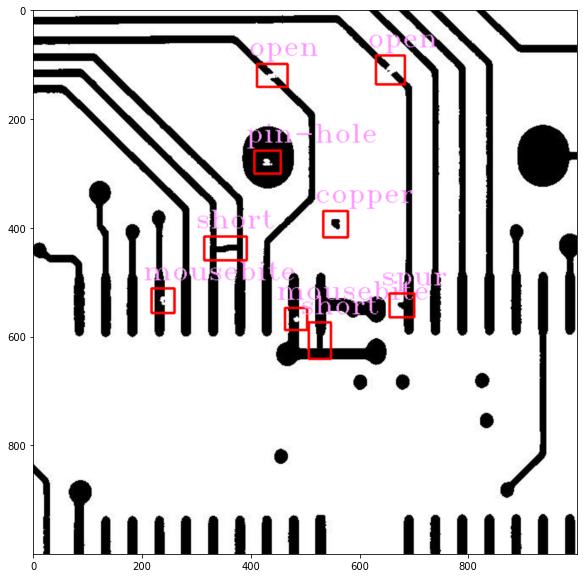

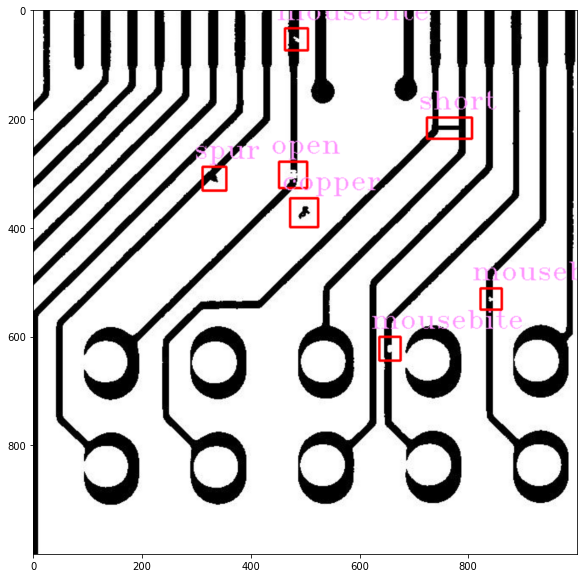

In [113]:
img_id=0
for _,row in test_data.iloc[0:10].iterrows():
  if row.id != img_id:
    img_id=row.id
    img_path='/content/tmp/images/test/'+str(img_id)+'.jpg'
    path_txt = glob.glob('/content/DeepPCB/PCBData/**/*{}'.format(str(img_id)+'.txt'), recursive=True)
    print(path_txt)
    print(img_path)
    img=cv2.imread(img_path)

    with open(path_txt[0], 'r') as f:

      for line in f.readlines():

        annot = (line.strip("\n").split(" "))

        x_min = int(annot[0])
        y_min = int(annot[1])
        x_max = int(annot[2])
        y_max = int(annot[3])
        label = int(annot[4])

        img=cv2.rectangle(img,(x_min,y_min),(x_max,y_max),color=(255,0,0),thickness=2)
        img_show=cv2.putText(img,classes[label],(int(x_min-10),int(y_min-10)),cv2.FONT_HERSHEY_TRIPLEX,1,color=[255,150,255],thickness = 1)
        img_show=cv2.resize(img_show, (1000,1000))    
    
    plt.figure(figsize=(10,10))
    plt.imshow(img_show)
  
  
   

In [83]:

print(folder_img_dir)

['/content/DeepPCB/PCBData/trainval.txt', '/content/DeepPCB/PCBData/test.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600028.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600012.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600076.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600074.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600021.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600040.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600048.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600077.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600019.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600057.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600037.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600023.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600007.txt', '/content/DeepPCB/PCBData/group50600/50600_not/50600014.txt', '/content/DeepPCB/PCBData/group50600/50600_not/506000